# Object Detection
* Group: 許佳綺、夏宇澄、黃鈺臻
* Deadline: 10/13

### <font color = yellow> 新增voc2012後更動的地方會標註 *voooc2012 以便整合 </font>

### Dataset Information
- PASCAL VOC 2007 + 2012(有刪去與2007重疊部分) *voooc2012
  - Number of class: 20
  - The data list is provided in the google drive. However, you have to download the training/testing data from http://host.robots.ox.ac.uk/pascal/VOC/voc2007/. 
    - Train/Val data: 5011 + 16369 *voooc2012
        - Each row contains one image and its bounding boxes.
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 0
    - Test data: 4951
        - filename ($x_{min}$, $y_{min}$, $x_{max}$, $y_{max}$, $label$) $\times$ object_num
        - class idx starts from 0


### Assignment
You are required to build a model to perform object detection on the provided Pascal VOC dataset in this project.

Here are some hints that help you to accomplish the project successfully.

### Hints
- YOLOv1 is the simplest and suggested model to be implemented.
- Be careful of the normalization techniques on bounding boxes.
    1. normalize the height and width with image size to fall into 0 and 1
    2. x and y coordinates are parameterized to be the offsets of a particular grid cell and also bounded by 0 and 1
- Loss function has a great impact on training stability.
    1. loss function is the most important in this project, especially in calculating IOU
    2. only one bounding box predictor is responsible for each object
    3. weights for different types of losses
    4. predict the square root of height and width instead of predicting them directly
- Data augmentation.
    1. It contains only 5011 images in total. Furthermore, the labels are highly imbalanced.
    2. Random scaling and translations are applied when training YOLO.
    3. Note that the bounding box coordinates have to be changed accordingly if the image was transformed.

### Evaluation Metric
- Please evaluate your model on Pascal VOC testing set using Mean Average Precision (mAP).
- Write a brief report including your implementation, performance and  qualitative results(visualize bounding box on some images). 
- For more detailed explanation of mAP, please follow https://github.com/rafaelpadilla/Object-Detection-Metrics

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
root = '/content/drive/My Drive/Project01_Object-Detection/'

In [4]:
GRID_NUM = 7

## Dataset
1. Loading
2. Parsing data list
2. Data preprocessing (including augmentation)
  - Do transforming(augmenting) when the loader is iterated

In [5]:
import os.path
import random
import numpy as np
import torch
import torch.utils.data as data
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt

class yoloDataset(data.Dataset):
    image_size = 448 # Size to be aligned

    # ---------------------- Parsing data list ---------------------- 
    def __init__(self,root,list_file,train,transform):
        self.root = root
        self.train = train
        self.transform = transform
        self.fnames = []
        self.boxes = []
        self.labels = []
        self.mean = (123,117,104) # RGB

        with open(list_file) as f:
            lines  = f.readlines()

        # format of each line: filename (x_min, y_min, x_max, y_max, label) * object_num
        for line in lines:
            splited = line.strip().split() # .strip(): reomove space, tab from the end of each line
            self.fnames.append(splited[0])
            num_boxes = (len(splited) - 1) // 5
            box=[]
            label=[]
            for i in range(num_boxes):
                x = float(splited[1+5*i])
                y = float(splited[2+5*i])
                x2 = float(splited[3+5*i])
                y2 = float(splited[4+5*i])
                c = splited[5+5*i]
                box.append([x,y,x2,y2])
                label.append(int(c)+1) # +1: since the idx start from 0
            self.boxes.append(torch.Tensor(box))
            self.labels.append(torch.LongTensor(label))
        self.num_samples = len(self.boxes)

    # ---------------------- Data preprocessing, augmentation ---------------------- 
    # Getting single transformed, preprocessed image and its target
    def __getitem__(self,idx):
        fname = self.fnames[idx]
        img = cv2.imread(os.path.join(self.root+fname))
        boxes = self.boxes[idx].clone()
        labels = self.labels[idx].clone()

        # Randomly transforming image
        if self.train:
            img, boxes = self.random_flip(img, boxes)
            img,boxes = self.randomScale(img,boxes)
            img = self.randomBlur(img)
            img = self.RandomBrightness(img)
            img = self.RandomHue(img)
            img = self.RandomSaturation(img)
            img,boxes,labels = self.randomShift(img,boxes,labels)
            img,boxes,labels = self.randomCrop(img,boxes,labels)

        # debug: showing the transformed image
        # box_show = boxes.numpy().reshape(-1)
        # img_show = self.BGR2RGB(img)
        # pt1=(int(box_show[0]),int(box_show[1])); pt2=(int(box_show[2]),int(box_show[3]))
        # cv2.rectangle(img_show,pt1=pt1,pt2=pt2,color=(0,255,0),thickness=1)
        # plt.figure()
        
        # plt.imshow(img_show)
        # plt.show()

        h,w,_ = img.shape
        boxes /= torch.Tensor([w,h,w,h]).expand_as(boxes) 
        # .expand_as(other): expand this tensor as other
        # [w, h, w, h] (1, 4) will be expanded to (#box, 4)
        img = self.BGR2RGB(img) # because pytorch pretrained model use RGB
        img = self.subMean(img,self.mean)
        img = cv2.resize(img,(self.image_size,self.image_size))
        target = self.encoder(boxes,labels) # 7x7x30, where 30 = 5*2(xywh+confidence for 2 boxes) + 20(classes)
        for t in self.transform:
            img = t(img)

        return img,target

    def __len__(self):
        return self.num_samples

    # Encoding the boxes, labels for single image
    def encoder(self,boxes,labels):
        grid_num = GRID_NUM
        target = torch.zeros((grid_num,grid_num,30))
        cell_size = 1./grid_num
        wh = boxes[:,2:]-boxes[:,:2]
        cxcy = (boxes[:,2:]+boxes[:,:2])/2 # center
        for i in range(cxcy.size()[0]): # = range(# of boxes)
            cxcy_sample = cxcy[i]
            ij = (cxcy_sample/cell_size).ceil()-1 # cell index
            target[int(ij[1]),int(ij[0]),4] = 1 # 4, 9: index of confindence of 2 box
            target[int(ij[1]),int(ij[0]),9] = 1
            target[int(ij[1]),int(ij[0]),int(labels[i])+9] = 1 # int(labels[i])+9: index of corresponding class's probablity
            xy = ij*cell_size # upper left coordinates of corresponding grid
            delta_xy = (cxcy_sample -xy)/cell_size
            target[int(ij[1]),int(ij[0]),:2] = delta_xy # x and y coordinates are parameterized to be the offsets of a particular grid cell
            target[int(ij[1]),int(ij[0]),2:4] = wh[i] 
            target[int(ij[1]),int(ij[0]),5:7] = delta_xy
            target[int(ij[1]),int(ij[0]),7:9] = wh[i]
            
        return target
        
    def BGR2RGB(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    def BGR2HSV(self,img):
        return cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
    def HSV2BGR(self,img):
        return cv2.cvtColor(img,cv2.COLOR_HSV2BGR)
    
    def subMean(self,bgr,mean):
        mean = np.array(mean, dtype=np.float32)
        bgr = bgr - mean
        return bgr
    
    def RandomBrightness(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv) # hue, saturation, value(brightness)
            adjust = random.choice([0.5,1.5])
            v = v*adjust
            v = np.clip(v, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr
        
    # discarded version of random brightness:
    def random_bright(self, im, delta=16):
        alpha = random.random()
        if alpha > 0.3:
            im = im * alpha + random.randrange(-delta,delta)
            im = im.clip(min=0,max=255).astype(np.uint8)
        return im

    def RandomSaturation(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            s = s*adjust
            s = np.clip(s, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def RandomHue(self,bgr):
        if random.random() < 0.5:
            hsv = self.BGR2HSV(bgr)
            h,s,v = cv2.split(hsv)
            adjust = random.choice([0.5,1.5])
            h = h*adjust
            h = np.clip(h, 0, 255).astype(hsv.dtype)
            hsv = cv2.merge((h,s,v))
            bgr = self.HSV2BGR(hsv)
        return bgr

    def randomBlur(self,bgr):
        if random.random()<0.5:
            bgr = cv2.blur(bgr,(5,5)) # get average with kernel size 5*5
        return bgr

    def randomShift(self,bgr,boxes,labels):
        center = (boxes[:,2:]+boxes[:,:2])/2
        if random.random() <0.5:
            height,width,c = bgr.shape
            after_shfit_image = np.zeros((height,width,c),dtype=bgr.dtype)
            after_shfit_image[:,:,:] = (104,117,123) #bgr
            shift_x = random.uniform(-width*0.2,width*0.2)
            shift_y = random.uniform(-height*0.2,height*0.2)

            if shift_x>=0 and shift_y>=0:
                after_shfit_image[int(shift_y):,int(shift_x):,:] = bgr[:height-int(shift_y),:width-int(shift_x),:]
            elif shift_x>=0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),int(shift_x):,:] = bgr[-int(shift_y):,:width-int(shift_x),:]
            elif shift_x <0 and shift_y >=0:
                after_shfit_image[int(shift_y):,:width+int(shift_x),:] = bgr[:height-int(shift_y),-int(shift_x):,:]
            elif shift_x<0 and shift_y<0:
                after_shfit_image[:height+int(shift_y),:width+int(shift_x),:] = bgr[-int(shift_y):,-int(shift_x):,:]

            shift_xy = torch.FloatTensor([[int(shift_x),int(shift_y)]]).expand_as(center)
            center = center + shift_xy
            mask1 = (center[:,0] >0) & (center[:,0] < width)
            mask2 = (center[:,1] >0) & (center[:,1] < height)
            mask = (mask1 & mask2).view(-1,1)
            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if len(boxes_in) == 0:
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[int(shift_x),int(shift_y),int(shift_x),int(shift_y)]]).expand_as(boxes_in)
            boxes_in = boxes_in+box_shift
            labels_in = labels[mask.view(-1)]
            return after_shfit_image,boxes_in,labels_in
        return bgr,boxes,labels

    def randomScale(self,bgr,boxes):
        if random.random() < 0.5:
            scale = random.uniform(0.8,1.2)
            height,width,c = bgr.shape
            bgr = cv2.resize(bgr,(int(width*scale),height)) # fix height, and scale the width
            scale_tensor = torch.FloatTensor([[scale,1,scale,1]]).expand_as(boxes)
            boxes = boxes * scale_tensor
            return bgr,boxes
        return bgr,boxes

    def randomCrop(self,bgr,boxes,labels):
        if random.random() < 0.5:
            center = (boxes[:,2:]+boxes[:,:2])/2
            height,width,c = bgr.shape
            h = random.uniform(0.6*height,height)
            w = random.uniform(0.6*width,width)
            x = random.uniform(0,width-w)
            y = random.uniform(0,height-h)
            x,y,h,w = int(x),int(y),int(h),int(w)

            center = center - torch.FloatTensor([[x,y]]).expand_as(center)
            mask1 = (center[:,0]>0) & (center[:,0]<w)
            mask2 = (center[:,1]>0) & (center[:,1]<h)
            mask = (mask1 & mask2).view(-1,1)

            boxes_in = boxes[mask.expand_as(boxes)].view(-1,4)
            if(len(boxes_in)==0):
                return bgr,boxes,labels
            box_shift = torch.FloatTensor([[x,y,x,y]]).expand_as(boxes_in)

            boxes_in = boxes_in - box_shift
            boxes_in[:,0]=boxes_in[:,0].clamp_(min=0,max=w)
            boxes_in[:,2]=boxes_in[:,2].clamp_(min=0,max=w)
            boxes_in[:,1]=boxes_in[:,1].clamp_(min=0,max=h)
            boxes_in[:,3]=boxes_in[:,3].clamp_(min=0,max=h)

            labels_in = labels[mask.view(-1)]
            img_croped = bgr[y:y+h,x:x+w,:]
            return img_croped,boxes_in,labels_in
        return bgr,boxes,labels

    def random_flip(self, im, boxes):
        if random.random() < 0.5:
            im_lr = np.fliplr(im).copy()
            h,w,_ = im.shape
            xmin = w - boxes[:,2]
            xmax = w - boxes[:,0]
            boxes[:,0] = xmin
            boxes[:,2] = xmax
            return im_lr, boxes
        return im, boxes

## Resnet50 backbone

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import BasicBlock, Bottleneck
from torchvision.models.resnet import model_urls
from torchsummary import summary

class classify_bottleneck(nn.Module):
  expansion = 1

  def __init__(self, inplanes, planes, stride=1, block_type='A'):
    super(classify_bottleneck, self).__init__()
    self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
    self.bn1 = nn.BatchNorm2d(planes)
    self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=2, bias=False,dilation=2)
    self.bn2 = nn.BatchNorm2d(planes)
    self.conv3 = nn.Conv2d(planes, planes, kernel_size=1, bias=False)
    self.bn3 = nn.BatchNorm2d(planes)

    self.downsample = nn.Sequential()
    if stride != 1 or block_type=='B':
        self.downsample = nn.Sequential(
            nn.Conv2d(inplanes, planes, kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(self.expansion*planes)
        )

  def forward(self, x):
    out = F.relu(self.bn1(self.conv1(x)))
    out = F.relu(self.bn2(self.conv2(out)))
    out = self.bn3(self.conv3(out))
    out += self.downsample(x)
    out = F.relu(out)
    return out

class ResNetYoloV1(nn.Module):

    def __init__(self, resnet_type):
	
        resnet_spec = {18: (BasicBlock, [2, 2, 2, 2], [64, 64, 128, 256, 512], 'resnet18'),
		       34: (BasicBlock, [3, 4, 6, 3], [64, 64, 128, 256, 512], 'resnet34'),
		       50: (Bottleneck, [3, 4, 6, 3], [64, 256, 512, 1024, 2048], 'resnet50'),
		       101: (Bottleneck, [3, 4, 23, 3], [64, 256, 512, 1024, 2048], 'resnet101'),
		       152: (Bottleneck, [3, 8, 36, 3], [64, 256, 512, 1024, 2048], 'resnet152')}
        block, layers, channels, name = resnet_spec[resnet_type]
        
        self.name = name
        self.inplanes = 64
        super(ResNetYoloV1, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.layer5 = self._make_classify_layer(in_channels=2048) #2048*14*14

        self.conv_end = nn.Conv2d(256, 30, kernel_size=3, stride=2, padding=1, bias=False)#30*7*7
        self.bn_end = nn.BatchNorm2d(30)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                # nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.normal_(m.weight, mean=0, std=0.001)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def _make_classify_layer(self,in_channels):
        layers = []
        layers.append(classify_bottleneck(inplanes=in_channels, planes=256, block_type='B'))
        layers.append(classify_bottleneck(inplanes=256, planes=256))
        layers.append(classify_bottleneck(inplanes=256, planes=256))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x1 = self.layer1(x)
        x2 = self.layer2(x1)
        x3 = self.layer3(x2)
        x4 = self.layer4(x3)
        # x4 layer output size: (B, 2048, 7, 7)
        x5 = self.layer5(x4)
        x = self.conv_end(x5)
        x = self.bn_end(x)
        x = torch.sigmoid(x) #归一化到0-1
        # x = x.view(-1,7,7,30)
        x = x.permute(0,2,3,1) #(-1,7,7,30)
        return x

    def init_weights(self):
        org_resnet = torch.utils.model_zoo.load_url(model_urls[self.name])
        # drop orginal resnet fc layer, add 'None' in case of no fc layer, that will raise error
        org_resnet.pop('fc.weight', None)
        org_resnet.pop('fc.bias', None)

        self.load_state_dict(org_resnet)
        print("Initialize resnet from model zoo")

def load_change_weights(model, model_name):
  
  org_resnet = torch.utils.model_zoo.load_url(model_urls[model_name])
  org_resnet.pop('fc.weight', None)
  org_resnet.pop('fc.bias', None)

  dd = model.state_dict()
  for k in org_resnet.keys():
      # print(k)
      if k in dd.keys() and not k.startswith('fc'):
          # print('yes')
          dd[k] = org_resnet[k]
  model.load_state_dict(dd)
  return model

## Yolov1 Loss


In [17]:
# Loss function
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class yolov1Loss(nn.Module):
    def __init__(self, S, B, C, lambda_coord, lambda_noobj):
        # Args:
        #    S: size of grid
        #    B: number of box
        #    C: number of class
        super(yolov1Loss, self).__init__()
        self.S = S 
        self.B = B 
        self.C = C 
        self.l_coord = lambda_coord
        self.l_noobj = lambda_noobj
    
    def calculateIoU(self, box1, box2):
        # calculate the intersection over the union of two sets of boxes, each box contains [xmin,ymin,xmax,ymax]
        # Args:
        #    size of box1 = [n,4]
        #    size of box2 = [m,4]
        # Return:
        #    size of Iou of two sets of boxes = [n,m]
        n = box1.size(0)
        m = box2.size(0)
        
        # take the max of left-bottom point and the min of right-top point 
        # to calculate the left-top point and the right-bottom point of the intersection
        lt = torch.max(
            box1[:,:2].unsqueeze(1).expand(n,m,2), # take [xmin,ymin]: [n,2] -> [n,1,2] -> [n,m,2]
            box2[:,:2].unsqueeze(0).expand(n,m,2)  # take [xmin,ymin]: [m,2] -> [1,m,2] -> [n,m,2]
        )
        
        rb = torch.min(
            box1[:,2:].unsqueeze(1).expand(n,m,2), # take [xmax,ymax]: [n,2] -> [n,1,2] -> [n,m,2]
            box2[:,2:].unsqueeze(0).expand(n,m,2)  # take [xmax,ymax]: [m,2] -> [1,m,2] -> [n,m,2]
        )
        
        # calculate weight and height of intersection areas and check if intersection area is 0
        wh = rb - lt # [n,m,2]
        wh[wh<0] = 0 # if max_left >= min_right or max_bottom >= min_top, then there is no intersection
        intersection = wh[:,:,0] * wh[:,:,1] # [n,m]
        
        area1 = (box1[:,2]-box1[:,0])*(box1[:,3]-box1[:,1])  #[n,]     
        area2 = (box2[:,2]-box2[:,0])*(box2[:,3]-box2[:,1])  #[m,]
        area1 = area1.unsqueeze(1).expand(n,m) # [n,] -> [n,1] -> [n,m]
        area2 = area2.unsqueeze(0).expand(n,m) # [m,] -> [1,m] -> [n,m]
        
        iou = intersection / (area1 + area2 - intersection)
        return iou
    def forward(self, preds, targets):
        # Args:
        #    size of preds = [batchsize, S, S, Bx5+20]: Bx5 means each box has [x,y,w,h,c] 5 values
        #    size of targets = [batchsize, S, S, Bx5+20]
        S, B, C = self.S, self.B, self.C
        N = B * 5 + C 
        batchsize = preds.size(0)
        coord_mask = targets[:,:,:,4] > 0        
        noobj_mask = targets[:,:,:,4] == 0
        coord_mask = coord_mask.unsqueeze(-1).expand(batchsize, S, S, N)        
        noobj_mask = noobj_mask.unsqueeze(-1).expand(batchsize, S, S, N)
        
        coord_pred = preds[coord_mask].view(-1, N)
        box_pred = coord_pred[:,:5*B].contiguous().view(-1, 5)
        class_pred = coord_pred[:,5*B:]
        
        coord_target = targets[coord_mask].view(-1, N)
        box_target = coord_target[:,:5*B].contiguous().view(-1, 5)
        class_target = coord_target[:,5*B:]
        
        # compute noobj_loss: only calculate confidence loss
        noobj_pred = preds[noobj_mask].view(-1, N)
        noobj_target = targets[noobj_mask].view(-1, N)
        noobj_pred_mask = torch.cuda.BoolTensor(noobj_pred.size())
        noobj_pred_mask.zero_()
        for b in range(B):
            noobj_pred_mask[:, 4+b*5] = 1
        noobj_pred_conf = noobj_pred[noobj_pred_mask]
        noobj_target_conf = noobj_target[noobj_pred_mask]  
        loss_noobj = F.mse_loss(noobj_pred_conf, noobj_target_conf, reduction = 'sum')
        
        # compute coord_loss
        coord_response_mask = torch.cuda.BoolTensor(box_target.size()).fill_(0) # only compute the loss of the box containing the center of object
        box_target_iou = torch.zeros(box_target.size()).cuda()
        
        # Choose the pred box having the highest IoU for each target boxes
        for i in range(0, box_target.size(0), B):
            # take all predict boxes at i-th cell
            pred_boxes = box_pred[i:i+B]
            pred_xyxy = Variable(torch.FloatTensor(pred_boxes.size()))
            pred_xyxy[:, :2] = pred_boxes[:, :2]/float(S) - 0.5*pred_boxes[:,2:4]
            pred_xyxy[:, 2:4] = pred_boxes[:, :2]/float(S) + 0.5*pred_boxes[:,2:4]   
            
            # take all target boxes at i-th cell
            # Since target boxes contained by each cell are identical in current implement,thus just take the first one
            target_boxes = box_target[i].view(-1, 5)
            target_xyxy = Variable(torch.FloatTensor(target_boxes.size()))
            target_xyxy[:, :2] = target_boxes[:, :2]/float(S) - 0.5*target_boxes[:,2:4]
            target_xyxy[:, 2:4] = target_boxes[:, :2]/float(S) + 0.5*target_boxes[:,2:4]
                                   
            iou = self.calculateIoU(pred_xyxy[:,:4], target_xyxy[:,:4]) # [B,1]
            max_iou, max_index = iou.max(0)
            max_index = max_index.data.cuda()
            
            coord_response_mask[i+max_index] = 1
            box_target_iou[i+max_index, torch.LongTensor([4]).cuda()] = (max_iou).data.cuda()
        
        # calculate the loss of the response boxes
        box_target_iou = Variable(box_target_iou).cuda()
        box_pred_response = box_pred[coord_response_mask].view(-1, 5)
        box_target_response = box_target[coord_response_mask].view(-1, 5)
        target_iou = box_target_iou[coord_response_mask].view(-1, 5)
        loss_xy = F.mse_loss(box_pred_response[:,:2], box_target_response[:,:2], reduction = 'sum')
        loss_wh = F.mse_loss(torch.sqrt(box_pred_response[:,2:4]), torch.sqrt(box_target_response[:,2:4]), reduction = 'sum')                
        loss_obj = F. mse_loss(box_pred_response[:,4], target_iou[:,4], reduction = 'sum')
        
        # calculate the class probability loss of cells containing objects
        loss_class = F.mse_loss(class_pred, class_target, reduction = 'sum')
        
        # total loss
        loss = self.l_coord * (loss_xy + loss_wh) + loss_obj + self.l_noobj*loss_noobj + loss_class
        loss = loss/float(batchsize)
                                   
        return loss

## Training Process


In [8]:
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torchvision.transforms as transforms

In [9]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")

In [11]:
batch_size = 12 # *voooc2012
momentum = 0.9
decay = 0.001
epochs = 5

train_loss = []
valid_loss = []

def train():
  ## model initiate
  learning_rate = 0.001
  yolov1 = ResNetYoloV1(50)
  yolov1 = load_change_weights(yolov1, 'resnet50')

  net = yolov1
  net.cuda()
  optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum = momentum, weight_decay=decay)
  # load data

  train_dataset = yoloDataset(root=root+'voc2007_n_12/',list_file=root+'voc2007train_n_12.txt', train=True,transform = [transforms.ToTensor()] ) # *voooc2012 # 2 new file: voc2007train_n_12.txt & new image folder
  train_loader = DataLoader(train_dataset,batch_size=batch_size,shuffle=True,num_workers=2) # *voooc2012
  # UserWarning: This DataLoader will create 4 worker processes in total. 
  # Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. 
  # Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  test_dataset = yoloDataset(root=root+'voc2007_n_12/',list_file=root+'voc2007valid.txt',train=False,transform = [transforms.ToTensor()] )
  test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False,num_workers=2)
  print('the dataset has %d images' % (len(train_dataset)))
  print('the batch_size is %d' % (batch_size))
  # training process
  criterion = yolov1Loss(GRID_NUM,2,20,5,0.5)
  best_val_loss = np.inf
  for ep in range(epochs):
    net.train()
    if ep >= 2:
      learning_rate = 0.01
    if ep >= 30:
      learning_rate = 0.001
    if ep >= 45:
      learning_rate = 0.0001
    for param_group in optimizer.param_groups:
      param_group['lr'] = learning_rate
    total_loss = 0.
    total_data = 0.
    for i, (images, target) in enumerate(train_loader):
        images = Variable(images)
        target = Variable(target)
        images,target = images.cuda(),target.cuda()
        batch_size_this_iter = images.size(0)

        pred = net(images)
        loss = criterion(pred,target)
        total_loss += loss.item()*batch_size_this_iter
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_data += batch_size_this_iter

        if (i+1) % 5 == 0:
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f, average_loss: %.4f' 
            %(ep+1, epochs, i+1, len(train_loader), loss.item(), total_loss / total_data))
            train_loss.append(total_loss / total_data)
    #validation process
    validation_loss = 0.0
    net.eval()
    for i, (images, target) in enumerate(test_loader):
      images = Variable(images)
      target = Variable(target)
      images, target = images.cuda(), target.cuda()

      pred = net(images)
      loss = criterion(pred, target)
      validation_loss += loss.item()
    validation_loss/=len(test_loader)
    print('Test epoch [%d/%d], average_loss: %.4f'%(ep+1, epochs, validation_loss))
    valid_loss.append(validation_loss)
    torch.save(net.state_dict(), root+'model_latest_12.pth') # *voooc2012
    if best_val_loss > validation_loss:
        best_val_loss = validation_loss
        torch.save(net.state_dict(), root+'model_best_12.pth') # *voooc2012

train()

the dataset has 19869 images
the batch_size is 12
Epoch [1/5], Iter [5/1656] Loss: 18.7215, average_loss: 23.7868
Epoch [1/5], Iter [10/1656] Loss: 17.2326, average_loss: 22.1516
Epoch [1/5], Iter [15/1656] Loss: 19.6278, average_loss: 21.0283
Epoch [1/5], Iter [20/1656] Loss: 14.5955, average_loss: 20.3119
Epoch [1/5], Iter [25/1656] Loss: 12.5210, average_loss: 18.7749
Epoch [1/5], Iter [30/1656] Loss: 11.2692, average_loss: 17.4470
Epoch [1/5], Iter [35/1656] Loss: 10.8054, average_loss: 16.6044
Epoch [1/5], Iter [40/1656] Loss: 9.0781, average_loss: 15.6333
Epoch [1/5], Iter [45/1656] Loss: 12.1201, average_loss: 14.9646
Epoch [1/5], Iter [50/1656] Loss: 11.1894, average_loss: 14.4444
Epoch [1/5], Iter [55/1656] Loss: 7.9039, average_loss: 13.7786
Epoch [1/5], Iter [60/1656] Loss: 8.2224, average_loss: 13.2465
Epoch [1/5], Iter [65/1656] Loss: 6.3042, average_loss: 12.8071
Epoch [1/5], Iter [70/1656] Loss: 6.8193, average_loss: 12.3736
Epoch [1/5], Iter [75/1656] Loss: 5.5649, aver

In [ ]:
plt.plot(valid_loss)
plt.title('model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['validation'], loc='best')
plt.show()

## Testing

In [19]:
# Predict function (output bounding box, not 7*7*30 target)

import torch
from torch.autograd import Variable
import torch.nn as nn
import torchvision.transforms as transforms
import cv2
import numpy as np

VOC_CLASSES = ('aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair',
        'cow', 'diningtable', 'dog', 'horse',
        'motorbike', 'person', 'pottedplant',
        'sheep', 'sofa', 'train', 'tvmonitor')

def decoder(pred, nms_thr=0.5, prob_thr=0.1):
    # turn 1*7*7*30 output into final prediced boxes (decode + nms)
    '''
    pred (tensor) 1x7x7x30, where 30 = 5*2(xywh+confidence for 2 boxes) + 20(classes)
    return (tensor) box[[x1,y1,x2,y2]] label[...]
    '''
    grid_num = GRID_NUM
    boxes=[]
    cls_indexs=[]
    probs = []
    cell_size = 1./grid_num
    pred = pred.data
    pred = pred.squeeze(0) # 7x7x30

    contain1 = pred[:,:,4].unsqueeze(2) # 4, 9: confidence for 2 boxes
    contain2 = pred[:,:,9].unsqueeze(2) # unsqueeze: Size = [7,7,1]
    contain = torch.cat((contain1,contain2),2) # shape: torch.Size([7, 7, 2])

    # mask for confidence (not class probability!)
    mask1 = contain > prob_thr # if confidence < thr, then confidence*max_prob must < thr. So we can discard it now.

    for i in range(grid_num):
        for j in range(grid_num):
          if mask1[i][j][0] and mask1[i][j][1]:
            if contain[i][j][0] >= contain[i][j][1]: 
              mask1[i][j][1] = False
            else:
              mask1[i][j][0] = False

    mask2 = (contain==contain.max())

    mask = (mask1+mask2).gt(0) # .gt(0): whether it is greater than zero 
                   # shape: torch.Size([7, 7, 2])
                   # keep a confidence if it > 0.1 or it is max among all confidence values

    for i in range(grid_num):
        for j in range(grid_num):
            for b in range(2):
                if mask[i,j,b] == 1:
                    box = pred[i,j,b*5:b*5+4] # get delta_x, delat_y, w, h
                    contain_prob = torch.FloatTensor([pred[i,j,b*5+4]])
                    xy = torch.FloatTensor([j,i])*cell_size # up left of cell
                    box[:2] = box[:2]*cell_size + xy # return cxcy relative to image
                    box_xy = torch.FloatTensor(box.size()) # convert[cx,cy,w,h] to [x1,xy1,x2,y2]
                    box_xy[:2] = box[:2] - 0.5*box[2:]
                    box_xy[2:] = box[:2] + 0.5*box[2:]
                    max_prob,cls_index = torch.max(pred[i,j,10:],0) # get the class with max prob

                    if float((contain_prob*max_prob)[0]) > prob_thr: # confidence * prob > 0.1
                        boxes.append(box_xy.view(1,4))
                        cls_indexs.append(cls_index.view(1))
                        probs.append(contain_prob*max_prob)
    # type of boxes, probs, cls_indexs: list of tensors

    if len(boxes) ==0: # ensure output shape, and set probs as 0 so it won't lead to further error.
        boxes = torch.zeros((1,4))
        probs = torch.zeros(1)
        cls_indexs = torch.zeros(1)
    else:
        boxes = torch.cat(boxes,0) #turn list of tensors into [N,4]
        # Debug: RuntimeError: zero-dimensional tensor (at position 0) cannot be concatenated
        # -> add .view(1) to cls_indexs before appending

        probs = torch.cat(probs,0) # [N,]
        cls_indexs = torch.cat(cls_indexs,0) # [N,]

    keep = nms(boxes,probs,nms_thr)
    return boxes[keep],cls_indexs[keep],probs[keep]

def nms(bboxes,scores,threshold=0.5):
    '''
    bboxes(tensor) [N,4]
    scores(tensor) [N,]
    return (tensor) [N,] indexs of the kept boxes
    '''
    x1 = bboxes[:,0]
    y1 = bboxes[:,1]
    x2 = bboxes[:,2]
    y2 = bboxes[:,3]
    areas = (x2-x1) * (y2-y1)

    _,order = scores.sort(0,descending=True) # return sorted values and their original index

    keep = []

    # use order to store the index of remaining boxes.
    # remove selected, discarded indexs for each round, the selected indexs will be stored in keep
    # run until there's no remaaining boxes.

    while order.numel() > 0: # return number of elements
                   # while there're items remain

        # take the first item
        if order.dim() == 0: # when dim()==0, can't use order[0].
          i = order.item() # item(): 
        else: 
          i = order[0]
        keep.append(i)

        if order.numel() == 1: # only 1 item remain: select it and stop.
            break
        
        # calculating the IoU between first item and others

        xx1 = x1[order[1:]].clamp(min=x1[i]) # clamp(min): turn values that < min into min. 
        xx2 = x2[order[1:]].clamp(max=x2[i])
        yy1 = y1[order[1:]].clamp(min=y1[i])
        yy2 = y2[order[1:]].clamp(max=y2[i])

        # weight and height of intersection areas
        w = (xx2-xx1).clamp(min=0)
        h = (yy2-yy1).clamp(min=0)
        inter = w*h
        # iou value of fist item vs other
        ovr = inter / (areas[i] + areas[order[1:]] - inter) 

        # discard those IoU with first item > threshold
        ids = (ovr<=threshold).nonzero().squeeze()
        
        if ids.numel() == 0: # if there's no item remain
            break
        order = order[ids+1]
        # ids+1 = indexs of items to keep for this round
        # ids is calculated for item[1:] 
        # -> before use it as the index of 'order', we have to +1.
        # example:  
        #   original order: tensor([ 6,  0,  4, 18,  7, 17, 14,  9,  1,  3, 13,  5, 11, 10])
        #   ids+1: tensor([ 1,  2,  3,  5,  7,  8,  9, 10, 11, 12, 13])
        #   new order:  tensor([ 0,  4, 18, 17,  9,  1,  3, 13,  5, 11, 10])
        # since the ids has +1, the first item(item with biggest prob) must be eliminated for each round

    return torch.LongTensor(keep)

# predict one image
def predict_gpu(model,image_name,root_path=''):

    result = []
    image = cv2.imread(root_path+image_name)

    h,w,_ = image.shape
    img = cv2.resize(image,(448,448))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    mean = (123,117,104) # RGB
    img = img - np.array(mean,dtype=np.float32)
    transform = transforms.Compose([transforms.ToTensor(),])
    img = transform(img)
    
    with torch.no_grad():
      img = Variable(img[None,:,:,:])
    img = img.cuda()

    pred = model(img) #1x7x7x30
    pred = pred.cpu()
    boxes,cls_indexs,probs = decoder(pred)

    for i,box in enumerate(boxes):
        x1 = int(box[0]*w)
        x2 = int(box[2]*w)
        y1 = int(box[1]*h)
        y2 = int(box[3]*h)
        cls_index = cls_indexs[i]
        cls_index = int(cls_index) # convert LongTensor to int
        prob = probs[i]
        prob = float(prob)
        result.append([(x1,y1),(x2,y2),VOC_CLASSES[cls_index],image_name,prob])
    return result

In [20]:
# Evaluate function

import numpy as np
def voc_ap(rec,prec):
    mrec = np.concatenate(([0.],rec,[1.]))
    mpre = np.concatenate(([0.],prec,[0.]))

    # smoothen the precision/recall curve (compute the envelope)
    for i in range(mpre.size -1, 0, -1):
        mpre[i-1] = np.maximum(mpre[i-1],mpre[i])

    # to calculate area under PR curve, look for points
    # where X axis (recall) changes value
    i = np.where(mrec[1:] != mrec[:-1])[0]

    # and sum the change of recall * prec
    ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])

    return ap

def voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES,threshold=0.5):
    '''
    preds {'cat':[[image_id,confidence,x1,y1,x2,y2],...],'dog':[[],...]}
    target {(image_id,class):[[],]}
    '''
    aps = []
    for i,class_ in enumerate(VOC_CLASSES):
        pred = preds[class_] # [[image_id,confidence,x1,y1,x2,y2],...]
        if len(pred) == 0: # abnormal case: none of object is detected as this class
            ap = -1
            print('---class {} ap {}---'.format(class_,ap))
            aps += [ap]
            break

        image_ids = [x[0] for x in pred]
        confidence = np.array([float(x[1]) for x in pred])
        BB = np.array([x[2:] for x in pred])
        # sort by confidence
        sorted_ind = np.argsort(-confidence)
        sorted_scores = np.sort(-confidence)
        BB = BB[sorted_ind, :]
        image_ids = [image_ids[x] for x in sorted_ind]

        # go down dets and mark TPs and FPs
        npos = 0.
        for (key1,key2) in target:
            if key2 == class_: # count the positive sameple for this class
                npos += len(target[(key1,key2)]) 
        nd = len(image_ids)
        tp = np.zeros(nd)
        fp = np.zeros(nd)
        for d,image_id in enumerate(image_ids):
            bb = BB[d] # bounding box
            if (image_id,class_) in target:
                BBGT = target[(image_id,class_)] #[[],]
                for bbgt in BBGT:
                    # compute overlaps
                    # intersection
                    ixmin = np.maximum(bbgt[0], bb[0])
                    iymin = np.maximum(bbgt[1], bb[1])
                    ixmax = np.minimum(bbgt[2], bb[2])
                    iymax = np.minimum(bbgt[3], bb[3])
                    iw = np.maximum(ixmax - ixmin + 1., 0.)
                    ih = np.maximum(iymax - iymin + 1., 0.)
                    inters = iw * ih

                    union = (bb[2]-bb[0]+1.)*(bb[3]-bb[1]+1.) + (bbgt[2]-bbgt[0]+1.)*(bbgt[3]-bbgt[1]+1.) - inters
                    if union == 0:
                        print(bb,bbgt)
                    
                    overlaps = inters/union
                    if overlaps > threshold:
                        tp[d] = 1
                        BBGT.remove(bbgt) # the box is already paired
                        if len(BBGT) == 0:
                            del target[(image_id,class_)] # delete the one without box
                        break
                fp[d] = 1-tp[d]
            else:
                fp[d] = 1
        fp = np.cumsum(fp)
        tp = np.cumsum(tp)
        rec = tp/float(npos)
        prec = tp/np.maximum(tp + fp, np.finfo(np.float64).eps)

        ap = voc_ap(rec, prec)
        print('---class {} ap {}---'.format(class_,ap))
        aps += [ap]
    print('---map {}---'.format(np.mean(aps)))

In [28]:
import cv2

Color = [[0, 0, 0],[128, 0, 0],[0, 128, 0],[128, 128, 0],
      [0, 0, 128],[128, 0, 128],[0, 128, 128],[128, 128, 128],
      [64, 0, 0],[192, 0, 0],[64, 128, 0],[192, 128, 0],
      [64, 0, 128],[192, 0, 128],[64, 128, 128],[192, 128, 128],
      [0, 64, 0],[128, 64, 0],[0, 192, 0],[128, 192, 0],[0, 64, 128]]

def visualize_image(image_name):
  model = ResNetYoloV1(50)
  model.load_state_dict(torch.load(root+'model_best_12.pth')) # *voooc2012
  model.eval()
  model.cuda()

  image = cv2.imread(root+'voc2007test_images/'+image_name)
  
  image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)


  result = predict_gpu(model,root+'voc2007test_images/'+image_name)
  for left_up,right_bottom,class_name,_,prob in result:
    color = Color[VOC_CLASSES.index(class_name)]
    cv2.rectangle(image,left_up,right_bottom,color,2)
    label = class_name+str(round(prob,2))
    text_size, baseline = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.4, 1)
    p1 = (left_up[0], left_up[1]- text_size[1])
    cv2.rectangle(image, (p1[0] - 2//2, p1[1] - 2 - baseline), (p1[0] + text_size[0], p1[1] + text_size[1]), color, -1)
    cv2.putText(image, label, (p1[0], p1[1] + baseline), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255,255,255), 1, 8)

  plt.figure(figsize=(10,10))
  plt.imshow(image)

In [29]:
# Testing & evaluating model
from collections import defaultdict # don't need to check if the key exists or not
from tqdm import tqdm # visualize progress

target =  defaultdict(list) 
preds = defaultdict(list)
image_list = [] #image path list

# prepare target
f = open(root+'voc2007test.txt')
lines = f.readlines()
file_list = []
for line in lines:
    splited = line.strip().split()
    file_list.append(splited)
f.close()

for index,image_file in enumerate(file_list):
    image_id = image_file[0]

    image_list.append(image_id)
    num_obj = (len(image_file) - 1) // 5
    for i in range(num_obj):
        x1 = int(image_file[1+5*i])
        y1 = int(image_file[2+5*i])
        x2 = int(image_file[3+5*i])
        y2 = int(image_file[4+5*i])
        c = int(image_file[5+5*i])
        class_name = VOC_CLASSES[c]
        target[(image_id,class_name)].append([x1,y1,x2,y2])

# start test
print('---start test---')
model = ResNetYoloV1(50)
model.load_state_dict(torch.load(root+'model_best_12.pth')) # *voooc2012
model.eval()
model.cuda()

# predict
for image_path in tqdm(image_list):
    result = predict_gpu(model,image_path,root_path=root+'voc2007test_images/') 
    # result[[left_up,right_bottom,class_name,image_path],]

    for (x1,y1),(x2,y2),class_name,image_id,prob in result: #image_id is actually image_path
        preds[class_name].append([image_id,prob,x1,y1,x2,y2])
    
# evaluate
print('---start evaluate---')
voc_eval(preds,target,VOC_CLASSES=VOC_CLASSES)

---start test---


100%|██████████| 4951/4951 [02:16<00:00, 36.37it/s]

---start evaluate---
---class aeroplane ap 0.4517269451870627---
---class bicycle ap 0.29422636384975964---
---class bird ap 0.043122748734981654---
---class boat ap -1---
---map -0.052730985557049---


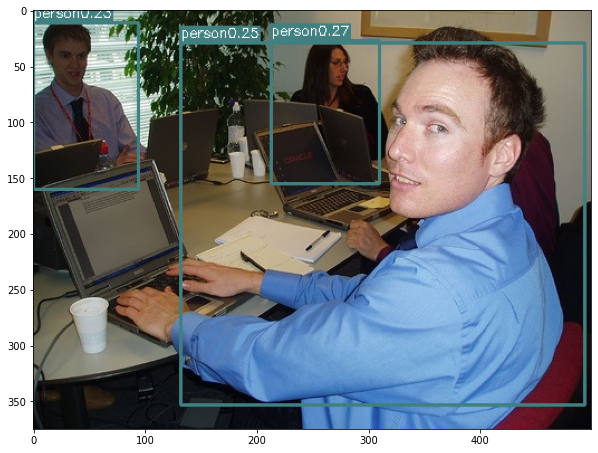

In [26]:
# Visualizing
visualize_image('000124.jpg')